In [83]:
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import cmocean

In [99]:
region = 'ningaloo_pass062'
# area = [113, -23, 115, -20.5] # Ningaloo
area = [113, -23, 114.5, -21.5] # Ningaloo
# x1,y1,x2,y2=area
x1,y1,x2,y2=[113.4,-22.7,114.2, -21.6]
x1,y1,x2,y2=[113.4,-22.7,114.4, -21.5]

satpass = '062' # 062 or 131
# ncfiles = sorted(glob(f'/home/jupyter-mrayson/data/SWOT/l3_karin_nadir_v1_0/cycle_0*/*_{satpass}*.nc'))
ncfiles = sorted(glob(f'/home/jupyter-mrayson/data/SWOT/l3_karin_unsmoothed/cycle_0*/*_{satpass}*.nc'))

# region = 'ningaloo_pass131'
# area = [113, -23, 115, -20.5] # Ningaloo
# ncfiles = sorted(glob('/home/jupyter-mrayson/data/SWOT/l3_karin_nadir_v1_0/cycle_0*/*_131*.nc'))

# region = 'browsebasin'
# area = [122.3, -14.5, 124, -13.5] 
# x1,y1,x2,y2=area
# # x1,y1,x2,y2=[113.4,-22.7,113.9, -21.8]
# satpass = '021' # 062 or 131
# ncfiles = sorted(glob(f'/home/jupyter-mrayson/data/SWOT/l3_karin_unsmoothed/cycle_*/*_{satpass}*.nc'))

In [100]:
# Merge all dataset

# from datetime import datetime
# def add_time_dim(xda):
#     #xda = xda.expand_dims(satpass = [datetime.now()])
#     xda = xda.expand_dims(satpass = [xda.time.mean().values])
#     return xda

# drop_vars=['i_num_line','i_num_pixel']
# dsall = xr.open_mfdataset(ncfiles, preprocess=add_time_dim, 
#                           drop_variables=drop_vars,
#                          )

len(ncfiles)

14

'FIGURES/SWOT_L3_unsmoothed_ningaloo_pass062_20240419T153807Z.png'

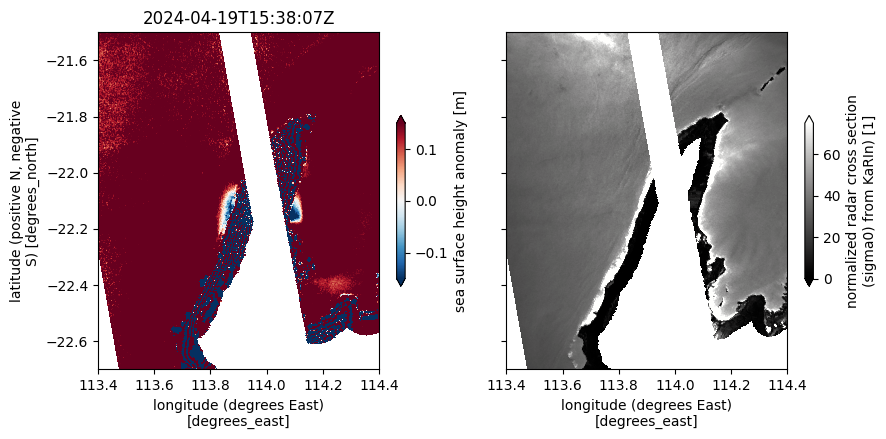

In [101]:
time =11

dsall = xr.open_dataset(ncfiles[time])
# Subsample
ds = dsall
selection = (
    (ds.longitude > area[0]) &
    (ds.longitude < area[2]) &
    (ds.latitude > area[1]) &
    (ds.latitude < area[3]))
selection = selection.compute()
ds_area = ds.where(selection, drop=True)
ds_area


var1 = 'ssha_unedited'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="RdBu_r",
    vmin=-0.15,
    vmax=0.15,
    cbar_kwargs={"shrink": 0.3},)

ds_area[var1].plot.pcolormesh(ax=ax1, **plot_kwargs)
# ax1.pcolormesh(xs,ys,np.abs(dxs+1j*dys), vmin=0, vmax=0.1, cmap='bone_r', alpha=0.2)
# u,v = ds_area.isel(satpass=swottime)['ugosa'], \
#         ds_area.isel(satpass=swottime)['vgosa']
# ax1.quiver(xs, ys, u, v, scale_units='xy', scale=10)

ax1.set_title(ds_area.attrs['time_coverage_begin'])

var2 = 'sigma0'
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="cmo.gray",
    vmin=0,
    vmax=75,
    cbar_kwargs={"shrink": 0.3},)

ds_area[var2].plot.pcolormesh(ax=ax2, **plot_kwargs)

ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax1.set_aspect('equal')
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax2.set_aspect('equal')
ax2.set_ylabel('')
ax2.set_yticklabels([])
plt.tight_layout()

timestr = ds_area.attrs['time_coverage_begin'].replace('-','').replace(':','')
outfile = f'FIGURES/SWOT_L3_unsmoothed_{region}_{timestr}.png'
plt.savefig(outfile)
outfile

In [102]:
def plot_basemap(ax, xlims, ylims, fine_contours=False, swath=True):

    # Add bathy etc to the plot
    
    # Load some bathy data
    dsall = xr.open_dataset('~/data/Bathymetry/GA_WEL_NWS_250m_DEM.nc')
    dsZ = dsall.assign_coords(nx=dsall.X,ny=dsall.Y).sel(nx=slice(xlims[0],xlims[1]), ny=slice(ylims[0], ylims[1]))
    
    #c= plt.contour(dsZ['X'],dsZ['Y'],-dsZ['topo'],np.arange(0, 1000, 100),colors='k',linewidths=0.5)
    c= plt.contour(dsZ['X'],dsZ['Y'],-dsZ['topo'],[0,100,200],colors='0.5',linewidths=0.5)
    if fine_contours:
        c_= plt.contour(dsZ['X'],dsZ['Y'],-dsZ['topo'],np.arange(20,1000,10),colors='0.5',linewidths=0.2)

    p1=plt.plot(113.93323333333333, -21.859933333333334,'md') # Nin 75 m


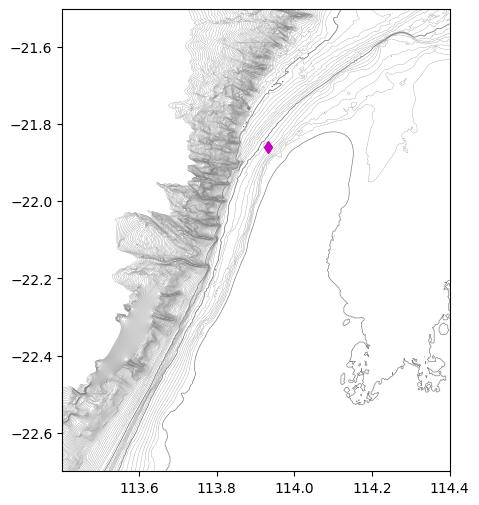

In [103]:
fig, ax1 = plt.subplots(1, 1,  figsize=(5,6))
plot_basemap(ax1, [x1,x2], [y1,y2], fine_contours=True)

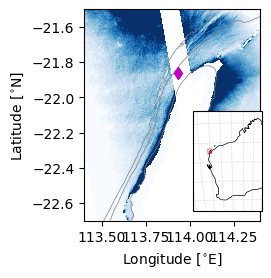

In [104]:
import cartopy.crs as ccrs

z = ds_area[var2].copy()
# dx, dy = np.gradient(z)
# z[:] = np.abs(dx+1j*dy)
z_mu = z.mean()
z_std = 50
z = (z-z_mu)/z_std

mapproj = ccrs.Orthographic(123.0, -14)

fig, ax1 = plt.subplots(1, 1, figsize=(3,4))

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Blues",
    vmin=-0.1,
    vmax=0.3,
    alpha=1,
    #cbar_kwargs={"shrink": 0.3}
    add_colorbar=False,)

z.plot.pcolormesh(ax=ax1, **plot_kwargs)

ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax1.set_aspect('equal')

plot_basemap(ax1, [x1,x2], [y1,y2], fine_contours=False)
ax1.set_ylabel('Latitude [$^{\circ}$N]')
ax1.set_xlabel('Longitude [$^{\circ}$E]')

plt.tight_layout()

extent = [110,128,-38,-12]
ax2 = fig.add_axes([0.65,0.30,0.25,0.25], projection=mapproj)

ax2.gridlines(lw=0.4, ls=':')
ax2.coastlines(resolution='50m', lw=0.5)
#ax.fill(xybox[:,0],xybox[:,1],transform=mapproj)
#ax2.plot(0,0,'ro',transform=mapproj)

xlims = [x1,x2]
ylims = [y1,y2]
xbox = [xlims[0], xlims[1],xlims[1], xlims[0], xlims[0]]
ybox = [ylims[0], ylims[0], ylims[1], ylims[1], ylims[0]]

ax2.plot(xbox, ybox,
         color='r', linewidth=0.4, marker='',
         transform=ccrs.Geodetic(), #remove this line to get straight lines
         )

ax2.set_extent(extent)

# plt.tight_layout()
outfile = f'FIGURES/SWOT_L3_backscatter_{region}_{timestr}.png'
plt.savefig(outfile, dpi=150)

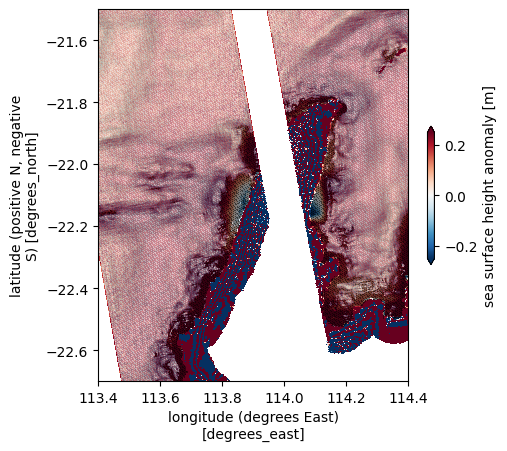

In [105]:
z = ds_area['ssha_noiseless'].copy()
dx, dy = np.gradient(z)
z[:] = np.abs(dx+1j*dy)
# z_mu = z.mean()
# z_std = 50
# z = (z-z_mu)/z_std

fig, ax1 = plt.subplots(1, 1, figsize=(5,6))

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="RdBu_r",
    vmin=-0.25,
    vmax=0.25,
    shading='flat',
    cbar_kwargs={"shrink": 0.3},)

ds_area[var1].plot.pcolormesh(ax=ax1, **plot_kwargs)

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="bone_r",
    vmin=0.0,
    vmax=0.005,
    alpha=0.5,
    shading='flat',
    add_colorbar=False,)

z.plot.pcolormesh(ax=ax1, **plot_kwargs)

ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax1.set_aspect('equal')

'FIGURES/SWOT_L3_unsmoothed_ningaloo_pass062_20240419T153807Z_w_grads.png'

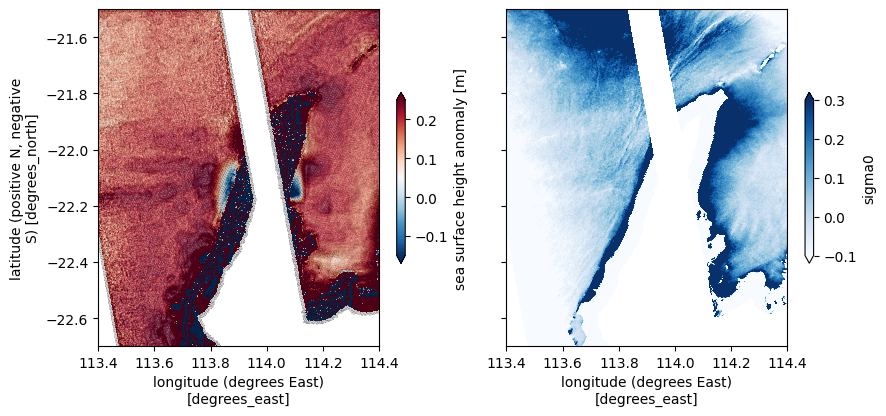

In [106]:
from sfoda.utils.filter2d import filter2d
from scipy.signal import convolve2d

z = ds_area['ssha_unedited'].copy()
#z = ds_area['sigma0'].copy()

zc = z.values#+1j
zc[np.isnan(zc)] = 0.
# zf,_,_,_ = filter2d(zc, 1, 1, 20, 0, 359.999, n=1)
# z[:] = np.abs(zf)

N=8
z[:] = convolve2d(zc, np.ones((N,N))/N**2, mode='same')

dx, dy = np.gradient(z)
z[:] = np.abs(dx+1j*dy)

# fig, ax1 = plt.subplots(1, 1, figsize=(5,6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="RdBu_r",
    vmin=-0.15,
    vmax=0.25,
    shading='flat',
    cbar_kwargs={"shrink": 0.3},)

ds_area[var1].plot.pcolormesh(ax=ax1, **plot_kwargs)


plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="bone_r",
    vmin=0.0,
    vmax=5e-3,
    alpha=0.2,
    shading='auto',
    add_colorbar=False,)

z.plot.pcolormesh(ax=ax1, **plot_kwargs)
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax1.set_aspect('equal')

z = ds_area[var2].copy()
# dx, dy = np.gradient(z)
# z[:] = np.abs(dx+1j*dy)
z_mu = z.mean()
z_std = 50
z = (z-z_mu)/z_std

# plot_kwargs = dict(
#     x="longitude",
#     y="latitude",
#     cmap="RdBu_r",
#     vmin=-0.25,
#     vmax=0.25,
#     cbar_kwargs={"shrink": 0.3},)

# ds_area[var1].plot.pcolormesh(ax=ax1, **plot_kwargs)

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Blues",
    vmin=-0.1,
    vmax=0.3,
    alpha=1,
    cbar_kwargs={"shrink": 0.3},)

z.plot.pcolormesh(ax=ax2, **plot_kwargs)

ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax2.set_aspect('equal')

ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax1.set_aspect('equal')
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax2.set_aspect('equal')
ax2.set_ylabel('')
ax2.set_yticklabels([])
plt.tight_layout()

timestr = ds_area.attrs['time_coverage_begin'].replace('-','').replace(':','')
outfile = f'FIGURES/SWOT_L3_unsmoothed_{region}_{timestr}_w_grads.png'
plt.savefig(outfile)
outfile

In [50]:
filter2d?

Signature: filter2d(Z3, dx, l_low, l_high, thetalow, thetahigh, n=8)
Docstring:
Two-dimensional wavenumber-directional Fourier transform filter.
Uses a Butterworth filter.

Inputs:
------
    z: 2D complex array
    dx: grid spacing
    l_low: shortest wavelength
    l_high: longest wavelength
    thetalow: low angle for filter (degrees CCW from E)
    thetahigh: high angle for filter (degrees CCW from E)
    
    n: (optional, default=8) order of the Butterworth filter
    
Outputs:
-----
    zf: 2D filtered complex array
    H: the filter function
    kx, ky: horizontal wavenumbers
File:      ~/code/sfoda/sfoda/utils/filter2d.py
Type:      function